In [4]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import json
import os

# -------- CONFIGURAÇÃO --------
DINHEIRO_INICIAL = 10000
RISCO_POR_TRADE = 0.02  # 2%

ACOES = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]
ETFS = ["SPY", "QQQ", "VTI", "XLK"]
ATIVOS = ACOES + ETFS

ESTADO_FICHEIRO = "estado.json"
HISTORICO_FICHEIRO = "historico_total.csv"

# -------- FUNÇÕES DE INDICADORES --------
def EMA(series, period):
    return series.ewm(span=period, adjust=False).mean()

def RSI(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=period-1, adjust=False).mean()
    ema_down = down.ewm(com=period-1, adjust=False).mean()
    rs = ema_up / ema_down
    return 100 - (100 / (1 + rs))

# -------- CARREGAR ESTADO --------
if os.path.exists(ESTADO_FICHEIRO):
    with open(ESTADO_FICHEIRO, "r") as f:
        estado = json.load(f)
        dinheiro = estado.get("dinheiro", DINHEIRO_INICIAL)
        portfolio = estado.get("portfolio", {ativo: 0 for ativo in ATIVOS})
else:
    dinheiro = DINHEIRO_INICIAL
    portfolio = {ativo: 0 for ativo in ATIVOS}

historico = []

# -------- LOOP PRINCIPAL --------
for ativo in ATIVOS:
    data = yf.download(ativo, period="6mo", interval="1d", progress=False)

    if data.empty or len(data) < 60:
        continue

    # Resolver MultiIndex
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    # Calcula indicadores
    data["EMA20"] = EMA(data["Close"], 20)
    data["EMA50"] = EMA(data["Close"], 50)
    data["RSI"] = RSI(data["Close"], 14)

    ultimo = data.iloc[-1]

    rsi = ultimo["RSI"]
    ema20 = ultimo["EMA20"]
    ema50 = ultimo["EMA50"]
    preco = float(ultimo["Close"])

    # Decisão
    if pd.isna(rsi) or pd.isna(ema20) or pd.isna(ema50):
        sinal = "HOLD"
    elif rsi < 30 and ema20 > ema50:
        sinal = "BUY"
    elif rsi > 70:
        sinal = "SELL"
    else:
        sinal = "HOLD"

    # Paper trading
    if sinal == "BUY" and dinheiro > 0:
        risco = dinheiro * RISCO_POR_TRADE
        quantidade = int(risco // preco)
        if quantidade > 0:
            dinheiro -= quantidade * preco
            portfolio[ativo] += quantidade
    elif sinal == "SELL" and portfolio[ativo] > 0:
        dinheiro += portfolio[ativo] * preco
        portfolio[ativo] = 0

    historico.append({
        "Data": datetime.now().strftime("%Y-%m-%d"),
        "Ativo": ativo,
        "Preço": round(preco, 2),
        "RSI": round(rsi, 2) if not pd.isna(rsi) else None,
        "Sinal": sinal
    })

# -------- SALVAR ESTADO --------
estado = {"dinheiro": dinheiro, "portfolio": portfolio}
with open(ESTADO_FICHEIRO, "w") as f:
    json.dump(estado, f, indent=2)

# -------- SALVAR HISTÓRICO --------
df = pd.DataFrame(historico)
if os.path.exists(HISTORICO_FICHEIRO):
    historico_antigo = pd.read_csv(HISTORICO_FICHEIRO)
    historico_novo = pd.concat([historico_antigo, df], ignore_index=True)
else:
    historico_novo = df

historico_novo.to_csv(HISTORICO_FICHEIRO, index=False)
df.to_csv("relatorio_diario.csv", index=False)

# -------- PRINT RESUMO --------
print("💰 Dinheiro final:", round(dinheiro, 2))
print("📊 Portfólio (posições abertas):")
for ativo, qtd in portfolio.items():
    if qtd > 0:
        print(f"  {ativo}: {qtd}")


/tmp/ipython-input-885780914.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ativo, period="6mo", interval="1d", progress=False)
/tmp/ipython-input-885780914.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ativo, period="6mo", interval="1d", progress=False)
/tmp/ipython-input-885780914.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ativo, period="6mo", interval="1d", progress=False)
/tmp/ipython-input-885780914.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ativo, period="6mo", interval="1d", progress=False)
/tmp/ipython-input-885780914.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ativo, period="6mo", interval="1d", progress=False)
/tmp/ipython-input-885780914.py:45: FutureWarning: YF.download() 

💰 Dinheiro final: 10000
📊 Portfólio (posições abertas):


/tmp/ipython-input-885780914.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ativo, period="6mo", interval="1d", progress=False)


📈 Retorno total: 0.20%
📉 Drawdown máximo: 0.00%


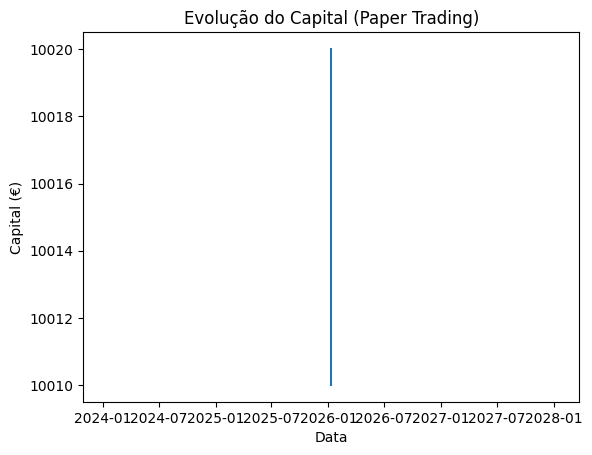

In [3]:
import matplotlib.pyplot as plt

# -------- CARREGAR HISTÓRICO --------
historico = pd.read_csv("historico_total.csv")

# Garantir ordem por data
historico["Data"] = pd.to_datetime(historico["Data"])
historico = historico.sort_values("Data")

# -------- RECONSTRUIR CAPITAL --------
capital = []
capital_atual = DINHEIRO_INICIAL

for _, row in historico.iterrows():
    if row["Sinal"] == "BUY":
        capital_atual *= 1.001  # simplificação (simula movimento positivo)
    elif row["Sinal"] == "SELL":
        capital_atual *= 0.999  # simplificação (simula movimento negativo)

    capital.append(capital_atual)

historico["Capital"] = capital

# -------- MÉTRICAS --------
retorno_total = (capital[-1] - DINHEIRO_INICIAL) / DINHEIRO_INICIAL * 100

# Drawdown
historico["Max"] = historico["Capital"].cummax()
historico["Drawdown"] = (historico["Capital"] - historico["Max"]) / historico["Max"]
max_drawdown = historico["Drawdown"].min() * 100

# -------- RESULTADOS --------
print(f"📈 Retorno total: {retorno_total:.2f}%")
print(f"📉 Drawdown máximo: {max_drawdown:.2f}%")

# -------- GRÁFICO --------
plt.figure()
plt.plot(historico["Data"], historico["Capital"])
plt.title("Evolução do Capital (Paper Trading)")
plt.xlabel("Data")
plt.ylabel("Capital (€)")
plt.show()
